In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
inspector = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

#Or we can use inspector 
print(inspector.get_table_names())

['measurement', 'station']
['measurement', 'station']


In [7]:
# Save references to each table
measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)

#Converting recent_date string into datetime type
recent_date = dt.datetime.strptime(recent_date[0],'%Y-%m-%d')

('2017-08-23',)


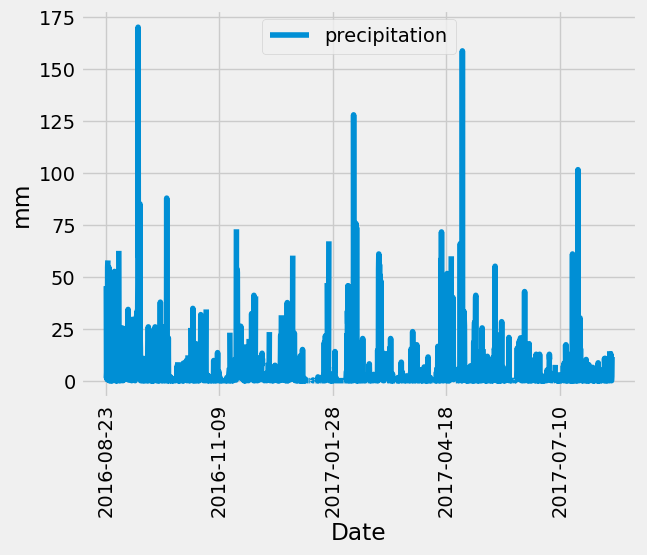

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
Year_min = (recent_date - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.prcp,measurement.date).\
    filter(measurement.date >= Year_min).\
    filter(measurement.date <= recent_date).all()

# # Save the query results as a Pandas DataFrame.
perp_year = pd.DataFrame(data=results)

# Sort the dataframe by date
perp_year = perp_year.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
perp_year.plot(y='prcp',x='date', rot=90,ylabel='mm',xlabel='Date',ax=ax)
ax.legend(['precipitation'])



In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
perp_year.describe()

,prcp
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).group_by(Station.station).count()

print(station_count)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

#Defining values we want from the query
sel = [measurement.station,
       func.count(measurement.station)]

#Query base on conditions
active_station = session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc())

#Print results
for row in active_station:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#defining the most active station by it station code
most_active = active_station.first()

#Filter the data for station matching the most active station 

#Selecting values we want
sel = [measurement.station,
       func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

#Query base on condition
most_active_temp = session.query(*sel).\
    filter(measurement.station==most_active.station)

#Print the results
for row in most_active_temp:
    print(row)

('USC00519281', 12.2, 29.4, 22.03582251082252)


In [15]:

#Find the most recent year entry for the most active station

#Query base on condition and orderby date descending then takes the date from the first row
ms_recent_date = session.query(measurement).\
    filter(measurement.station == most_active.station).\
    order_by(measurement.date.desc()).first().date


#Converts the string into a date
ms_recent_date = dt.datetime.strptime(ms_recent_date,'%Y-%m-%d')

#Calculate a year before the date
ms_year_min = ms_recent_date - dt.timedelta(days=365)

#Convert it into string
ms_year_min = ms_year_min.strftime('%Y-%m-%d')

<Axes: ylabel='Frequency'>

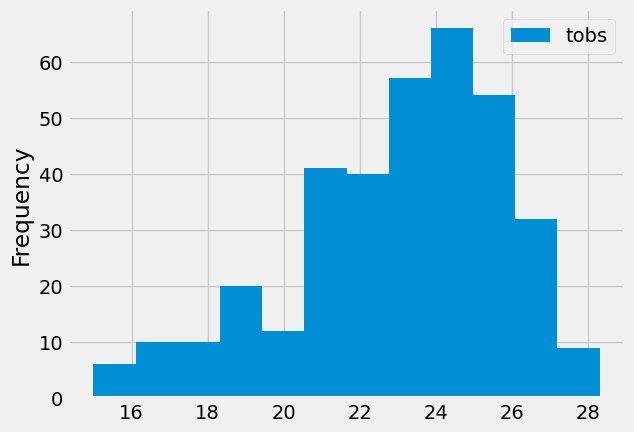

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Selection values
sel = [measurement.tobs,
       func.count(measurement.tobs).label('Frequency')]

#Query based on conditions
top_active_station_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active.station).\
    filter(measurement.date >= ms_year_min).\
    filter(measurement.date <= ms_recent_date).all()
    
#Convert reusults into a dataframe
m_active_station_year = pd.DataFrame(top_active_station_data)

#Plot histogram with bins=12
m_active_station_year.plot(kind='hist',bins=12,xlabel='Temperature')




# Close Session

In [17]:
# Close Session
session.close()